In [71]:
import numpy as np
import decimal
from numpy.linalg import inv
from commpy.modulation import QAMModem
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, BatchNormalization, Dropout, Conv1D,MaxPooling1D,GlobalAveragePooling1D, Flatten
from decimal import getcontext
import matplotlib.pyplot as plt

getcontext().Emax = 600000000000
import import_ipynb
from Utils import *
IBO = 3
p = 1.1
q = 4
Vsat = 1.9
G = 16
A = -345
B = 0.17
Mr = 10
Mt = 100
M = 16
N_bits = Mr * np.log2(M)
SNRdb = decimal.Decimal(60000000000)
Niter = 50
mu1 = 0.0017
lamda = 0.00071
mu2 = 1
eps = 1e-2

In [11]:
IH1=np.zeros((1000, 2000))
OH1=np.zeros((1000, 4620))
K0, sigma_2d = Basic_Nonlinear_Distortion_Model(A, B, q, p, G, Vsat, IBO)

""" Generate the matrix of the channel H ∈ ℂ(Mr * Mt) whose inputs are complex random Gaussian variables
    Transfer H Matrix into a vector that contains H Real values concatenated with H Imaginary values  """
for t in range(1000):
    N_bits = Mr * np.log2(M)
    x_gd = np.zeros((Mt, 1))
    gdx1 = np.zeros((Mt, Niter))
    d = np.zeros((Mt, 1))
    S = np.zeros((10000, 20))
    X = np.zeros((10000, 200))
    H = (1 / np.sqrt(2 * Mt)) * (np.random.randn(Mr, Mt) + 1j * np.random.randn(Mr, Mt))
    HR = H.flatten()
    realh = np.real(HR)
    imagh = np.imag(HR)
    Hr = np.concatenate((realh, imagh), axis=0)
    Hr = np.reshape(Hr, (2000, 1)).T
    HH = Hr
    HH.tolist()
     """Generate for each H; 10,000 symbols Z and 10,000 precoded symbols X by
    Generating a random bit stream equivalent to the transmissed signal then modulating this bit stream (16-QAM type modulation) using the QAMModem () function of the CommPy library
    Concatenate Z real part with Z imaginary part into S vector its size is (10000,20)
    Compute the gradient gradient in order to have X_gd which, when ampliﬁed and then passed through the channel, can guarantee excellent transmission quality.  
    The vector X contains precoded real symbols concatenated with the imaginary ones.
    Then update IBO Coefficients where Input Back-Off in a power amplifier, is a measure of how far you must reduce the input power in order to receive the desired output linearity and power.
    Determine the distortion vector (d) and the PA Gain complex (K0) using hpa_sspa_modif_rapp() and find_K0_sigma2_d() functions.
    Where Vin and Vout are the input / output of Power amplifier PA."""
    for j in range(10000):
        bits = np.random.randint(2, size=int(N_bits))  
        QAM16 = QAMModem(16)  
        z = QAM16.modulate(bits)
        Z = np.reshape(z, (1, 10))
        reals = np.real(Z)
        imags = np.imag(Z)
        s = np.concatenate((reals, imags), axis=1)
        S[j] = s
        for i in range(Niter):
            gdx1 = 2 * np.conj(K0 * np.transpose(H)).dot(K0 * H.dot(x_gd) + H.dot(d)- Z.T)
            x_gd = x_gd - mu1 * gdx1
            realx = np.real(x_gd)
            imagx = np.imag(x_gd)
            x_z = np.concatenate((realx, imagx), axis=0).reshape((200))
            X[j] = x_z
            val_IBO_m1dB = (((1 / np.sqrt(10 ** -0.1)) ** (2 * p) - 1) ** (1 / (2 * p)) * Vsat / (G))
            coeff_IBO_m1dB = (val_IBO_m1dB * np.sqrt((1 / np.var(x_gd))) * np.sqrt(10 ** (-IBO / 10)))  
            vin2 = coeff_IBO_m1dB * x_gd
            vout2 = hpa_sspa_modif_rapp(vin2, Vsat, p, q, G, A, B) 
            K0, sigma2_d = find_K0_sigma2_d(vin2, vout2)
            d = vout2 - K0 * vin2  
            y_gd =vout2 / coeff_IBO_m1dB
        MSEgd=np.mean(np.abs((H.dot(y_gd)) - Z.T) ** 2) / (np.mean(np.abs(Z) ** 2))
    NMSEGD = 10 * np.log10(np.mean(MSEgd))
    print('nmsede GD',NMSEGD)
    "Base d'apprentissage"
    X_train = S[:9000, :]
    y_train = X[:9000, :]
    "Base de test"
    X_test = S[9000:, :]
    y_test = X[9000:, :]
    model=Sequential()
    model.add(Dense(units=20, kernel_initializer="uniform", activation="linear", input_dim=20))
    model.add(Dense(units=200, kernel_initializer="uniform", activation="linear"))
    model.compile(optimizer="Adamax", loss="mae", metrics=['mse'])
    history = model.fit(
        X_train,
        y_train,
        validation_data=(X_test, y_test),
        batch_size=1000,
        epochs=300,
        shuffle=True,
    )
    #Calcul d NMSE
    y_pred = model.predict(X_train)
    y_predt = model.predict(X_test)
    NMSE = np.zeros([1000, 1])
    recievehh = np.zeros([1000, 10], dtype=complex)
    Y_gdr = y_predt[:1000, :100]
    Y_gdi = 1j * y_predt[:1000, 100:]
    Y_gd = Y_gdr + Y_gdi
    Shr = X_test[:1000, :10]
    Shi = 1j * X_test[:1000, 10:20]
    SSh = Shr + Shi
    for i in range(1000):
        val_IBO_m1dB = (((1 / np.sqrt(10 ** -0.1)) ** (2 * p) - 1) ** (1 / (2 * p)) * Vsat / (G))
        coeff_IBO_m1dB = (val_IBO_m1dB * np.sqrt((1 / np.var(Y_gd[i]))) * np.sqrt(10 ** (-IBO / 10)))
        vin22 = coeff_IBO_m1dB * Y_gd[i]
        vout22 = hpa_sspa_modif_rapp(vin22, Vsat, p, q, G, A, B)
        Y_gd_amp = vout22 / coeff_IBO_m1dB
        recieveh = (H.dot(Y_gd_amp)).reshape((10))
        recievehh[i] = recieveh
        NMSE[i] = np.mean(np.abs(SSh[i] - recieveh) ** 2) / np.mean(np.abs(SSh[i]) ** 2)
    NMSEdb = 10 * np.log10(np.mean(NMSE))
    print(NMSEdb )
    if NMSEdb< -32 :
        """ Recover the weight vector of our model NN1 using the function get_weights ().
        This vector will be the desired output of the NN2 model."""
        first_layer_weights =model.layers[0].get_weights()[0] 
        
        first=first_layer_weights.flatten()
        first_layer_biases  = model.layers[0].get_weights()[1]
        first_layer=np.concatenate((first,first_layer_biases),axis=0)
        second_layer_weights = model.layers[1].get_weights()[0]
        second=second_layer_weights.flatten()
        second_layer_biases  = model.layers[1].get_weights()[1]
        second_layer=np.concatenate((second,second_layer_biases),axis=0)
        weights=np.concatenate((first_layer,second_layer),axis=0)
        weights.tolist()
        print (t)
        IH1[t]=HH
        OH1[t]=weights
        save('dataI28.npy',IH1)
        save('dataO28.npy',OH1)
        print('canal numero ',t,'Saved')
    else:
        print('canal numero ',t,'Condition not satisfied')

nmsede GD -39.89514241380351
Epoch 1/300
9/9 [==============================] - 0s 11ms/step - loss: 0.0459 - mse: 0.0034 - val_loss: 0.0417 - val_mse: 0.0028
Epoch 2/300
9/9 [==============================] - 0s 3ms/step - loss: 0.0393 - mse: 0.0025 - val_loss: 0.0371 - val_mse: 0.0022
Epoch 3/300
9/9 [==============================] - 0s 3ms/step - loss: 0.0355 - mse: 0.0020 - val_loss: 0.0339 - val_mse: 0.0018
Epoch 4/300
9/9 [==============================] - 0s 3ms/step - loss: 0.0327 - mse: 0.0017 - val_loss: 0.0312 - val_mse: 0.0016
Epoch 5/300
9/9 [==============================] - 0s 3ms/step - loss: 0.0301 - mse: 0.0015 - val_loss: 0.0286 - val_mse: 0.0013
Epoch 6/300
9/9 [==============================] - 0s 3ms/step - loss: 0.0276 - mse: 0.0012 - val_loss: 0.0262 - val_mse: 0.0011
Epoch 7/300
9/9 [==============================] - 0s 3ms/step - loss: 0.0253 - mse: 0.0011 - val_loss: 0.0240 - val_mse: 9.4873e-04
Epoch 8/300
9/9 [==============================] - 0s 3ms/step 

KeyboardInterrupt: 

In [68]:
"""NN2 Database Preparation """
IH1=load('dataI1.npy')[np.nonzero(load('dataI1.npy' ))]
OH1=load('dataO1.npy')[np.nonzero(load('dataO1.npy' ))]
IH2=load('dataI2.npy')[np.nonzero(load('dataI2.npy' ))]
OH2=load('dataO2.npy')[np.nonzero(load('dataO2.npy' ))]
IH3=load('dataI3.npy')[np.nonzero(load('dataI3.npy' ))]
OH3=load('dataO3.npy')[np.nonzero(load('dataO3.npy' ))]
IH6=load('dataI6.npy')[np.nonzero(load('dataI6.npy' ))]
OH6=load('dataO6.npy')[np.nonzero(load('dataO6.npy' ))]
IH5=load('dataI5.npy')[np.nonzero(load('dataI5.npy'))]
OH5=load('dataO5.npy')[np.nonzero(load('dataO5.npy'))]
IH4=load('dataI4.npy')[np.nonzero(load('dataI4.npy' ))]
OH4=load('dataO4.npy')[np.nonzero(load('dataO4.npy' ))]
IH8=load('dataI8.npy')[np.nonzero(load('dataI8.npy' ))]
OH8=load('dataO8.npy')[np.nonzero(load('dataO8.npy' ))]
IH9=load('dataI9.npy')[np.nonzero(load('dataI9.npy'))]
OH9=load('dataO9.npy')[np.nonzero(load('dataO9.npy'))]
IH10=load('dataI10.npy')[np.nonzero(load('dataI10.npy' ))]
OH10=load('dataO10.npy')[np.nonzero(load('dataO10.npy' ))]
IH11=load('dataI11.npy')[np.nonzero(load('dataI11.npy' ))]
OH11=load('dataO11.npy')[np.nonzero(load('dataO11.npy' ))]
IH12=load('dataI12.npy')[np.nonzero(load('dataI12.npy'))]
OH12=load('dataO12.npy')[np.nonzero(load('dataO12.npy'))]
IH7=load('dataI7.npy')[np.nonzero(load('dataI7.npy' ))]
OH7=load('dataO7.npy')[np.nonzero(load('dataO7.npy' ))]
IH13=load('dataI13.npy')[np.nonzero(load('dataI13.npy'))]
OH13=load('dataO13.npy')[np.nonzero(load('dataO13.npy'))]
IH14=load('dataI14.npy')[np.nonzero(load('dataI14.npy'))]
OH14=load('dataO14.npy')[np.nonzero(load('dataO14.npy'))]
IH15=load('dataI15.npy')[np.nonzero(load('dataI15.npy'))]
OH15=load('dataO15.npy')[np.nonzero(load('dataO15.npy'))]
IH16=load('dataI16.npy')[np.nonzero(load('dataI16.npy'))]
OH16=load('dataO16.npy')[np.nonzero(load('dataO16.npy'))]
IH17=load('dataI17.npy')[np.nonzero(load('dataI17.npy'))]
OH17=load('dataO17.npy')[np.nonzero(load('dataO17.npy'))]
IH18=load('dataI18.npy')[np.nonzero(load('dataI18.npy'))]
OH18=load('dataO18.npy')[np.nonzero(load('dataO18.npy'))]
IH19=load('dataI19.npy')[np.nonzero(load('dataI19.npy'))]
OH19=load('dataO19.npy')[np.nonzero(load('dataO19.npy'))]
IH20=load('dataI20.npy')[np.nonzero(load('dataI20.npy'))]
OH20=load('dataO20.npy')[np.nonzero(load('dataO20.npy'))]
IH21=load('dataI21.npy')[np.nonzero(load('dataI21.npy'))]
OH21=load('dataO21.npy')[np.nonzero(load('dataO21.npy'))]
IH22=load('dataI22.npy')[np.nonzero(load('dataI22.npy'))]
OH22=load('dataO22.npy')[np.nonzero(load('dataO22.npy'))]
IH23=load('dataI23.npy')[np.nonzero(load('dataI23.npy'))]
OH23=load('dataO23.npy')[np.nonzero(load('dataO23.npy'))]
IH24=load('dataI24.npy')[np.nonzero(load('dataI24.npy'))]
OH24=load('dataO24.npy')[np.nonzero(load('dataO24.npy'))]
IH25=load('dataI25.npy')[np.nonzero(load('dataI25.npy'))]
OH25=load('dataO25.npy')[np.nonzero(load('dataO25.npy'))]
IH26=load('dataI26.npy')[np.nonzero(load('dataI26.npy'))]
OH26=load('dataO26.npy')[np.nonzero(load('dataO26.npy'))]
IH27=load('dataI27.npy')[np.nonzero(load('dataI27.npy'))]
OH27=load('dataO27.npy')[np.nonzero(load('dataO27.npy'))]
IHH=np.concatenate((IH1,IH2,IH3,IH4,IH5,IH6,IH8,IH9,IH10,IH11,IH12,IH7,IH13,IH14,IH15,IH16,IH17,IH18,IH19,IH20,IH21,IH22,IH23,IH24,IH25,IH26,IH27),axis=0)
OHH=np.concatenate((OH1,OH2,OH3,OH4,OH5,OH6,OH8,OH9,OH10,OH11,OH12,OH7,OH13,OH14,OH15,OH16,OH17,OH18,OH19,OH20,OH21,OH22,OH23,OH24,OH25,OH26,OH27),axis=0)
# creating a noise
IHHHH=[]
OHHHH=[]
for w in range(5):
    mu, sigma = 0, 0.0001 
    noise = np.random.normal(mu, sigma, [50367240,]) 
    noiseW=OHH+noise
    IHHH=np.concatenate((IHH, np.copy(IHH)),axis=0)
    IHHHH=np.append(IHHHH, IHHH)
    OHHH=np.concatenate((OHH, noiseW),axis=0)
    OHHHH=np.append(OHHHH,OHHH)
IHHHH=IHHHH.reshape((109020,2000))
OHHHH=OHHHH.reshape((109020,4620))
print(IHHHH.shape)    
print(OHHHH.shape)
X_trainN2 = IHHHH[:100000,:]
X_trainN2 = X_trainN2.reshape((X_trainN2.shape[0], X_trainN2.shape[1], 1))
y_trainN2 = OHHHH[:100000,:]
y_trainN2 = y_trainN2.reshape((y_trainN2.shape[0], y_trainN2.shape[1], 1))
X_testN2= IHHHH[100000:,:]
X_testN2 = X_testN2.reshape((X_testN2.shape[0], X_testN2.shape[1], 1))
y_testN2 = OHHHH[100000:,:]
y_testN2 = y_testN2.reshape((y_testN2.shape[0], y_testN2.shape[1], 1))

(109020, 2000)
(109020, 4620)


##NN2

In [72]:
"""Create NN2 Model which contains 2 hidden layers; 
The first layer have 1000 neurones (input_dim=2000)
The second have 4620 neurones (output_dim=4620) """
import tensorflow as tf
keras.optimizers.Adamax(learning_rate=0.9, beta_1=0.999, beta_2=0.999)
in_shape=X_trainN2.shape[1:]
print (in_shape)
modell=Sequential()
modell.add(Conv1D(filters=30, kernel_size=7, strides=1,activation='linear',input_shape=in_shape))
"""model.add(Conv1D(30, 5, activation='relu')) 
model.add(Dropout(0.5))
model.add(Conv1D(30, 4, activation='relu')) 
model.add(MaxPooling1D(3))"""
model.add(Flatten())
model.add(Dense(units=1000, activation="linear"))
modell.add(Dense(units=4620, kernel_initializer="uniform", activation="linear"))
modell.compile(optimizer="Adamax", loss="mae", metrics=['mse'])
history2 = modell.fit(X_trainN2,y_trainN2,validation_data=(X_testN2, y_testN2),batch_size=1000,epochs=200,shuffle=True,verbose = 2)
# Loss representation
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model loss')
plt.grid(True,which="both", linestyle='--')
plt.ylabel('Loss') 
plt.yscale('log')
plt.xlabel('Epoch')
plt.legend(['Train','Test'], loc='upper left')
plt.show()
# Make predictions
y_pred2 = modell.predict(X_trainN2)
y_predt2 = modell.predict(X_testN2)


(2000, 1)
Epoch 1/200


ValueError: in user code:

    /opt/conda/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:571 train_function  *
        outputs = self.distribute_strategy.run(
    /opt/conda/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:951 run  **
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /opt/conda/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:2290 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /opt/conda/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:2649 _call_for_each_replica
        return fn(*args, **kwargs)
    /opt/conda/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:533 train_step  **
        y, y_pred, sample_weight, regularization_losses=self.losses)
    /opt/conda/lib/python3.6/site-packages/tensorflow/python/keras/engine/compile_utils.py:205 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    /opt/conda/lib/python3.6/site-packages/tensorflow/python/keras/losses.py:143 __call__
        losses = self.call(y_true, y_pred)
    /opt/conda/lib/python3.6/site-packages/tensorflow/python/keras/losses.py:246 call
        return self.fn(y_true, y_pred, **self._fn_kwargs)
    /opt/conda/lib/python3.6/site-packages/tensorflow/python/keras/losses.py:1230 mean_absolute_error
        return K.mean(math_ops.abs(y_pred - y_true), axis=-1)
    /opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/math_ops.py:984 binary_op_wrapper
        return func(x, y, name=name)
    /opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/gen_math_ops.py:10103 sub
        "Sub", x=x, y=y, name=name)
    /opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py:744 _apply_op_helper
        attrs=attr_protos, op_def=op_def)
    /opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/func_graph.py:595 _create_op_internal
        compute_device)
    /opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/ops.py:3327 _create_op_internal
        op_def=op_def)
    /opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/ops.py:1817 __init__
        control_input_ops, op_def)
    /opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/ops.py:1657 _create_c_op
        raise ValueError(str(e))

    ValueError: Dimensions must be equal, but are 1994 and 4620 for '{{node mean_absolute_error/sub}} = Sub[T=DT_FLOAT](sequential_78/dense_143/BiasAdd, IteratorGetNext:1)' with input shapes: [1000,1994,4620], [1000,4620,1].


In [73]:
modell.summary()

Model: "sequential_78"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_59 (Conv1D)           (None, 1994, 30)          240       
_________________________________________________________________
dense_143 (Dense)            (None, 1994, 4620)        143220    
Total params: 143,460
Trainable params: 143,460
Non-trainable params: 0
_________________________________________________________________


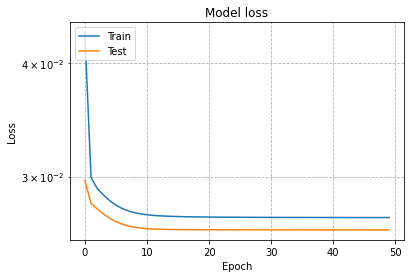

In [53]:
# Make predictions
y_pred2 = modell.predict(X_trainN2)
y_predt2 = modell.predict(X_testN2)

# Loss representation
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model loss')
plt.grid(True,which="both", linestyle='--')
plt.ylabel('Loss') 
plt.yscale('log')
plt.xlabel('Epoch')
plt.legend(['Train','Test'], loc='upper left')
plt.show()


In [46]:
first_layer_weightstt=y_predt2[:,:400]
print(first_layer_weightstt.shape)
first_layer_biasestt=y_predt2[:,400:420]
print(first_layer_biasestt.shape)
second_layer_weightstt=y_predt2[:,420:4420]
print(second_layer_weightstt.shape)
second_layer_biasestt=y_predt2[:,4420:]
print(second_layer_biasestt.shape)

(94020, 400)
(94020, 20)
(94020, 4000)
(94020, 200)


In [ ]:
pip install sklearn

In [ ]:
import sklearn.metrics
from sklearn.metrics import mean_absolute_error
Ih11=load('IH11.npy')[np.nonzero(load('IH11.npy' ))]
Oh11=load('OH11.npy')[np.nonzero(load('OH11.npy' ))]
Ih11=Ih11.reshape((429,2000))
Oh11=Oh11.reshape((429,4620))
y_predt3= modell.predict(Ih11[:1,:])
print(mean_absolute_error(y_predt3[:1,:],Oh11[:1,:]))


In [ ]:
plt.figure()
plt.plot(y_predt[1,:100],'b')
plt.plot(y_testN2[1,:100],'r')
ERR=(abs(y_predt2[5,:]-y_testN2[5,:])**2)
print(sum(ERR))
plt.figure()
plt.plot(ERR)

In [47]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, BatchNormalization
for t in range(900):
    NMSE2 = np.zeros((900, 1))
    H2r=X_testN2[t,:1000]
    H2i=1j*X_testN2[t,1000:]
    H02=H2r+H2i
    H2=H02.reshape((10,100))
    print('Canal numero:',t)
    S_NN1 =X_test[:900,:]
    modelll=Sequential()
    modelll.add(Dense(units=20, kernel_initializer="uniform", activation="linear", input_dim=20))
    first_weightstt=first_layer_weightstt[t,:400]
    L1=first_weightstt.reshape((20,20))
    first_layer_biasestt=y_predt2[t,400:420]
    L2=first_layer_biasestt
    modelll.layers[0].set_weights([L1,L2])
    modelll.add(Dense(units=200, kernel_initializer="uniform", activation="linear"))
    second_weightstt=y_predt2[t,420:4420]
    L3=second_weightstt.reshape((20,200))
    second_layer_biasestt=y_predt2[t,4420:4620]
    L4=second_layer_biasestt
    modelll.layers[1].set_weights([L3,L4]) 
    y_predt22 = modelll.predict(S_NN1)
    Y_gd2r = y_predt22[:900,:100]
    Y_gd2i = 1j * y_predt22[:900,100:]
    Y_gd2 = Y_gd2r + Y_gd2i
    print(Y_gd2.shape)
    Shr2 = S_NN1[:900, :10]
    Shi2 = 1j * S_NN1[:900, 10:20]
    SSh2 = Shr2 + Shi2
    for n in range(900):
        val_IBO_m1dB = (((1 / np.sqrt(10 ** -0.1)) ** (2 * p) - 1) ** (1 / (2 * p)) * Vsat / (G))
        coeff_IBO_m1dB22=val_IBO_m1dB * np.sqrt((1 / np.var(Y_gd2[n]))) * np.sqrt(10 ** (-IBO / 10))
        vin222 = coeff_IBO_m1dB22 * Y_gd2[n]
        vout222 = hpa_sspa_modif_rapp(vin222, Vsat, p, q, G, A, B)
        Y_gd_amp2 = vout222 / coeff_IBO_m1dB22
        recieveh2 = (H2.dot(Y_gd_amp2)).reshape((10))
        NMSE2[n]= np.mean(np.abs(SSh2[n] - recieveh2) ** 2) / np.mean(np.abs(SSh2[n]) ** 2)
    NMSE2db = 10 * np.log10(np.mean(NMSE2)) 
    print('NMSE de canal numero',t ,'est: ',NMSE2db) 
    #print('R',recieveh2)
    #print( 'SSH',SSh2)   


Canal numero: 0
(900, 100)
NMSE de canal numero 0 est:  -0.047953969855796495
Canal numero: 1
(900, 100)
NMSE de canal numero 1 est:  -0.061728517950511874
Canal numero: 2
(900, 100)
NMSE de canal numero 2 est:  -0.02399007361386424
Canal numero: 3
(900, 100)
NMSE de canal numero 3 est:  -0.07012059761866901
Canal numero: 4
(900, 100)
NMSE de canal numero 4 est:  -0.020423575483262648
Canal numero: 5
(900, 100)
NMSE de canal numero 5 est:  -0.05826881002975751
Canal numero: 6
(900, 100)
NMSE de canal numero 6 est:  -0.07178765599084459
Canal numero: 7
(900, 100)
NMSE de canal numero 7 est:  -0.03809120469274066
Canal numero: 8
(900, 100)
NMSE de canal numero 8 est:  -0.07144692994304687
Canal numero: 9
(900, 100)
NMSE de canal numero 9 est:  -0.019006906665060858
Canal numero: 10
(900, 100)
NMSE de canal numero 10 est:  0.0020058212758908476
Canal numero: 11
(900, 100)
NMSE de canal numero 11 est:  -0.045238942090756386
Canal numero: 12
(900, 100)
NMSE de canal numero 12 est:  -0.00739

KeyboardInterrupt: 

In [48]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, BatchNormalization
for t in range(900):
    H2r=X_testN2[t,:1000]
    H2i=1j*X_testN2[t,1000:]
    H02=H2r+H2i
    H2=H02.reshape((10,100))
    print('Canal numero:',t)
    S_NN1 =X_test[:900,:]
    modelll=Sequential()
    modelll.add(Dense(units=20, kernel_initializer="uniform", activation="linear", input_dim=20))
    first_weightsttV=y_testN2[t,:400]
    LV1=first_weightsttV.reshape((20,20))
    first_layer_biasesttV=y_testN2[t,400:420]
    LV2=first_layer_biasesttV
    modelll.layers[0].set_weights([LV1,LV2])
    modelll.add(Dense(units=200, kernel_initializer="uniform", activation="linear"))
    second_weightsttV=y_testN2[t,420:4420]
    LV3=second_weightsttV.reshape((20,200))
    second_layer_biasesttV=y_testN2[t,4420:4620]
    LV4=second_layer_biasesttV
    modelll.layers[1].set_weights([LV3,LV4]) 
    y_predt22v = modelll.predict(S_NN1)
    NMSE22 = np.zeros((900, 1))
    Y_gd2r = y_predt22v[:900,:100]
    Y_gd2i = 1j * y_predt22v[:900,100:]
    Y_gd2 = Y_gd2r + Y_gd2i
    print(Y_gd2.shape)
    Shr2 = S_NN1[:900, :10]
    Shi2 = 1j * S_NN1[:900, 10:20]
    SSh2 = Shr2 + Shi2
    for n in range(900):
        val_IBO_m1dB = (((1 / np.sqrt(10 ** -0.1)) ** (2 * p) - 1) ** (1 / (2 * p)) * Vsat / (G))
        coeff_IBO_m1dB22=val_IBO_m1dB * np.sqrt((1 / np.var(Y_gd2[n]))) * np.sqrt(10 ** (-IBO / 10))
        vin222 = coeff_IBO_m1dB22 * Y_gd2[n]
        vout222 = hpa_sspa_modif_rapp(vin222, Vsat, p, q, G, A, B)
        Y_gd_amp2 = vout222 / coeff_IBO_m1dB22
        recieveh2 = (H2.dot(Y_gd_amp2)).reshape((10))
        NMSE22[n]= np.mean(np.abs(SSh2[n] - recieveh2) ** 2) / np.mean(np.abs(SSh2[n]) ** 2)
    NMSE22db = 10 * np.log10(np.mean(NMSE22)) 
    print('NMSE de canal numero',t ,'est: ',NMSE22db) 

Canal numero: 0
(900, 100)
NMSE de canal numero 0 est:  -32.760072986034665
Canal numero: 1
(900, 100)
NMSE de canal numero 1 est:  -33.191773759648086
Canal numero: 2
(900, 100)
NMSE de canal numero 2 est:  -32.80616906628368
Canal numero: 3
(900, 100)
NMSE de canal numero 3 est:  -32.8390884646831
Canal numero: 4
(900, 100)
NMSE de canal numero 4 est:  -32.699499254037804
Canal numero: 5
(900, 100)
NMSE de canal numero 5 est:  -32.747793400864836
Canal numero: 6
(900, 100)
NMSE de canal numero 6 est:  -32.753637132192324
Canal numero: 7
(900, 100)
NMSE de canal numero 7 est:  -33.02459679291748
Canal numero: 8
(900, 100)
NMSE de canal numero 8 est:  -32.77775979846243
Canal numero: 9
(900, 100)


KeyboardInterrupt: 